In [1]:
import argparse
import cv2
import numpy as np
import networkx as nx
import os
from itertools import combinations
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import Compose
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from viz_3d import *

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d

import pypose as pp

from SLAM.UZH_FPV_Dataset import UZH_FPV_Dataset

os.chdir("./DepthAnything/")
from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

/home/ilari/miniconda3/envs/matine/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/ilari/miniconda3/envs/matine/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initialize Dataset

/home/ilari/Documents/MATINEDepthSemanticSLAM/SLAM/UZH_FPV_Dataset.py:84: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  R=torch.tensor([np.eye(3)]),


tensor([[259.9811,   0.0000, 298.3111],
        [  0.0000, 258.0602, 224.2180],
        [  0.0000,   0.0000,   1.0000]]) tensor([-0.0137,  0.0207, -0.0128,  0.0025,  0.0000,  0.0000]) (686, 518)
torch.Size([10, 3, 518, 686]) torch.Size([746, 1]) torch.Size([746, 3]) torch.Size([746, 3]) torch.Size([10, 7])


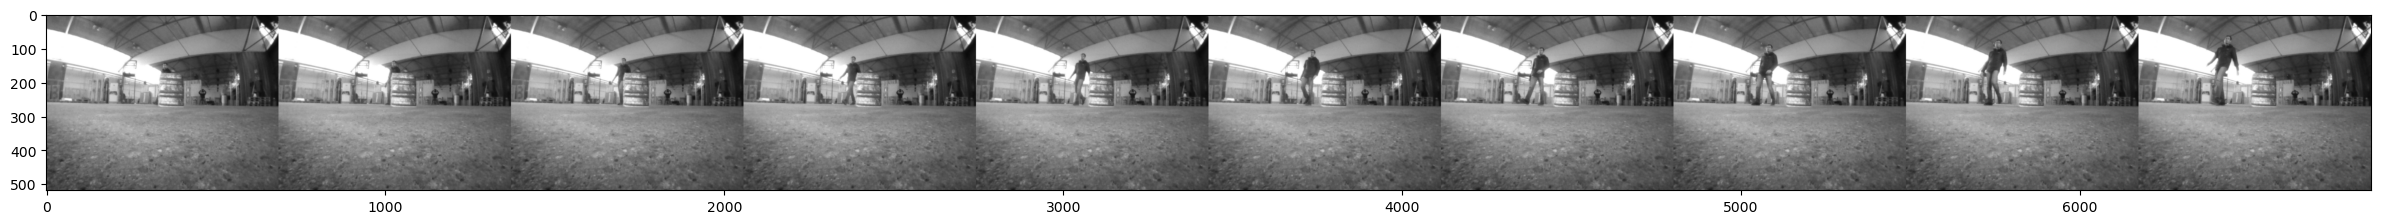

In [2]:
transform = Compose(
    [
        Resize(
            width=518,
            height=518,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method="lower_bound",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        # NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # PrepareForNet(),  # this makes the image (and training masks) contiguous and floats
    ]
)

seq_len = 10
skip_frames = 5

dataset = UZH_FPV_Dataset(
    path="/home/ilari/Downloads/indoor_forward_6_snapdragon_with_gt",
    transforms=transform,
    sequence_length=seq_len,
    skip_frames=skip_frames,
)

X = dataset[0]
print(X["cam0"].shape, X["dt"].shape, X["acc"].shape, X["gyro"].shape, X["gt_pose"].shape)

s, h, w, c = X["cam0"].shape

plt.figure(figsize=(30, 10))
plt.imshow(np.concatenate(tuple(X["cam0"].permute(0,2,3,1)), axis=1));

### Initialize Models

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Camera model
fish_cam = dataset.camera_model.to(device)

# Depth Anything
depth_anything = DepthAnything.from_pretrained("LiheYoung/depth_anything_vitb14").to(device).eval()
total_params = sum(param.numel() for param in depth_anything.parameters())
print("DepthAnything parameters: {:.2f}M".format(total_params / 1e6))

# Extractor and matcher
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)


# IMU
integrator = pp.module.IMUPreintegrator(gyro_cov=0.05, acc_cov=0.1, reset=True).to(device)

cuda
DepthAnything parameters: 97.47M


In [4]:
def DepthAnythingProcess(batch):
    mean = torch.tensor([0.485, 0.456, 0.406], device=batch.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=batch.device).view(1, 3, 1, 1)
    batch = (batch - mean) / std
    batch = batch.contiguous()
    return batch

def extract_keypoints(image, extractor, device):
    #image = load_image(img_path)
    feats = extractor.extract(image.to(device))
    return feats


def match_keypoints(feats0, feats1, matcher):
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]
    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
    return m_kpts0, m_kpts1, matches01

def covisibility_graph(cams, matches, G=None):
    if G is None:
        G = nx.Graph()

    for cam_idx in cams:
        for i, j in matches[cam_idx]:
            G.add_edge((cam_idx, i), (cam_idx + 1, j))

    TC = nx.transitive_closure(G, reflexive=False)
    components = nx.connected_components(TC)
    points3D = [sublist for sublist in components if len(sublist) >= 3]
    
    cam2point = defaultdict(list)
    for i, point in enumerate(points3D):
            for cam, feature_idx in point:
                cam2point[cam].append((feature_idx, i))

    return points3D, cam2point, TC


def triangulate_matched_points(points3D, covis_graph, cam2point, new_cams, camera_model, poses, batch_keypoints, batch_depths):

    # Concatenate zeros for new incoming points
    if points3D is None:
        points3D = torch.zeros((len(covis_graph), 3), device=poses.device)
    else:
        # Calculate how many new points to add.
        num_new_points = len(covis_graph) - points3D.shape[0]
        points3D = torch.cat([points3D, torch.zeros((num_new_points, 3), device=points3D.device)])

    for i, cam in enumerate(new_cams):
        indices = cam2point[cam]
        indices_2d = np.array([idx[0] for idx in indices])
        indices_3d = np.array([idx[1] for idx in indices])
        pose = poses[i]
        keypoints = batch_keypoints[cam]['keypoints'][0, indices_2d]
        depths = batch_depths[i, keypoints[:,1].int(), keypoints[:, 0].int()]

        #Remove points more than 25m away.
        # filter_depth = torch.where(depths < 50)[0].int().cpu().numpy()
        # indices_2d = indices_2d[filter_depth]
        # indices_3d = indices_3d[filter_depth]
        # cam2point[cam] = list(zip(indices_2d, indices_3d))
        # depths = depths[filter_depth]
        # keypoints = keypoints[filter_depth]
        unit_vectors = F.normalize(camera_model.unproject_points(keypoints))
        cam_sees_3dpts = pose @ (unit_vectors * depths.unsqueeze(1))
        points3D[indices_3d] = cam_sees_3dpts

    return points3D, cam2point


def batch2device(tensor_dict, device):
    return {k: v.to(device) for k, v in tensor_dict.items()}

In [5]:
K = torch.tensor(dataset.K).float().to(device)

/tmp/ipykernel_13534/566495070.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K = torch.tensor(dataset.K).float().to(device)


### Inference on whole sequence.

In [6]:
# Training loop for whole sequence
start = 930 // skip_frames
end = dataset.__len__() - 1

points3D = None
poses = []
gt_poses = []
feature_points = []
all_matches = []
num_cams = 0 
G = None 

for iter, data_idx in enumerate(range(start, end, seq_len)):
    data = batch2device(dataset[data_idx], device)
    image_batch = data["cam0"]

    # Get initial poses through IMU
    # if iter == 0:
    #     init_state = {
    #         'pos': data['gt_pose'][0].translation(),
    #         'rot' : data['gt_pose'][0].rotation(),
    #         'vel' : data['velocity']
    #     }
    # else:
    #     init_state = {
    #         'pos' : imu_poses[-1].translation(),
    #         'rot' : imu_poses[-1].rotation(),
    #         'vel' : state['vel'][0:1, -1]
    #     }

    init_state = {
            'pos': data['gt_pose'][0].translation(),
            'rot' : data['gt_pose'][0].rotation(),
            'vel' : data['velocity']
        }
    state = integrator(dt=data['dt'], 
                    gyro=data['gyro'],
                    acc=data['acc'],
                    init_state=init_state)

    imu_freq = data['dt'].shape[0] // image_batch.shape[0]
    imu_poses = pp.SE3(torch.cat((state['pos'], state['rot']), dim=-1))
    imu_poses = imu_poses[0, ::imu_freq][:image_batch.shape[0]]

    new_cams = range(num_cams, num_cams+image_batch.shape[0])
    num_cams += image_batch.shape[0]

    # Extract keypoints
    for i in range(image_batch.shape[0]):
        feature_points.append(extract_keypoints(image_batch[i:i+1], extractor, device))

    # Match keypoints
    if new_cams[0] != 0:
        m_kpts0, m_kpts1, matches01 = match_keypoints(feature_points[cam-1], feature_points[cam], matcher)
        all_matches.append(matches01["matches"].cpu().numpy())
    for cam in new_cams[:-1]:
        m_kpts0, m_kpts1, matches01 = match_keypoints(feature_points[cam], feature_points[cam+1], matcher)
        all_matches.append(matches01["matches"].cpu().numpy())

    # Covisibility graph should use previous graph and expand on it.
    covis_graph, cam2point, G = covisibility_graph(new_cams[:-1], all_matches, G)

    # Depth estimation
    with torch.no_grad():
        image_batch = DepthAnythingProcess(image_batch)
        depths = depth_anything(image_batch)
        
    # Triangulate new 3d points, and update points
    points3D, cam2point = triangulate_matched_points(points3D, covis_graph, cam2point, new_cams, fish_cam, imu_poses, feature_points, depths)

    poses.append(imu_poses)
    gt_poses.append(data['gt_pose'])

    # Delete large variables to conserve GPU memory
    # del depths
    # del data

    #if batch_idx > 40:    
    # break

/home/ilari/miniconda3/envs/matine/lib/python3.9/site-packages/pypose/lietensor/lietensor.py:918: UserWarning: Tensor Shape Invalid by calling <built-in method cat of type object at 0x7fb965849840>, go to https://pypose.org/docs/main/generated/pypose.LieTensor
  warnings.warn('Tensor Shape Invalid by calling {}, ' \


### Visualize Poses and Points for Initialized Conditions

In [43]:
def visualize_batch(poses, gt_poses, points):
    fig = init_figure()
    fig.update_layout(showlegend=True)
    for pose, gt_pose in zip(poses, gt_poses):
        R = pose.rotation().matrix().cpu().numpy()
        t = pose.translation().cpu().numpy()
        Rgt = gt_pose.rotation().matrix().cpu().numpy()
        tgt = gt_pose.translation().cpu().numpy()
        intrinsics = dataset.K.numpy()        
        plot_camera(fig, Rgt, tgt, intrinsics, text="gt", size=5, color="blue")
        plot_camera(fig, R, t, intrinsics, text="pred", size=5, color="green")

    X = points.cpu().numpy().squeeze()
    plot_points(fig, X, color='red')

    fig.show()

poses = torch.vstack(poses)
gt_poses = torch.vstack(gt_poses)
visualize_batch(poses, gt_poses , points3D)

TypeError: vstack(): argument 'tensors' (position 1) must be tuple of Tensors, not LieTensor

In [8]:
# # Training loop for one batch
# start = 930 // skip_frames
# end = dataset.__len__()

# for data_idx in range(start, end, seq_len):
#     data = batch2device(dataset[data_idx], device)
#     image_batch = data["cam0"]
#     feature_points = []
#     all_matches = []

#     # Get initial poses through IMU
#     init_state = {
#         'pos': data['gt_pose'][0].translation(),
#         'rot' : data['gt_pose'][0].rotation(),
#         'vel' : data['velocity']
#     }
#     state = integrator(dt=data['dt'], 
#                     gyro=data['gyro'],
#                     acc=data['acc'],
#                     init_state=init_state)
    
#     # plt.plot(data['gyro'].cpu().numpy())
#     # plt.figure()
#     # plt.plot(data['acc'].cpu().numpy())

#     # print(state)
    
#     imu_freq = data['dt'].shape[0] // image_batch.shape[0]
#     imu_poses = pp.SE3(torch.cat((state['pos'], state['rot']), dim=-1))
#     imu_poses = imu_poses[0, ::imu_freq][:image_batch.shape[0]]

#     # Extract keypoints
#     for i in range(image_batch.shape[0]):
#         feature_points.append(extract_keypoints(image_batch[i:i+1], extractor, device))

#     # Match keypoints
#     for i in range(len(feature_points)-1):
#         m_kpts0, m_kpts1, matches01 = match_keypoints(feature_points[i], feature_points[i+1], matcher)
#         all_matches.append(matches01["matches"].cpu().numpy())

#     # Create covisibility graph
#     covis_graph, cam2point = covisibility_graph(image_batch.shape[0], all_matches)
    
#     image_batch = DepthAnythingProcess(image_batch)

#     with torch.no_grad():
#         depths = depth_anything(image_batch)
#         depths = 1/depths

        
#     points3D, cam2point = triangulate_matched_points(covis_graph, fish_cam, imu_poses, feature_points, depths)

#     #if batch_idx > 40:    
#     break

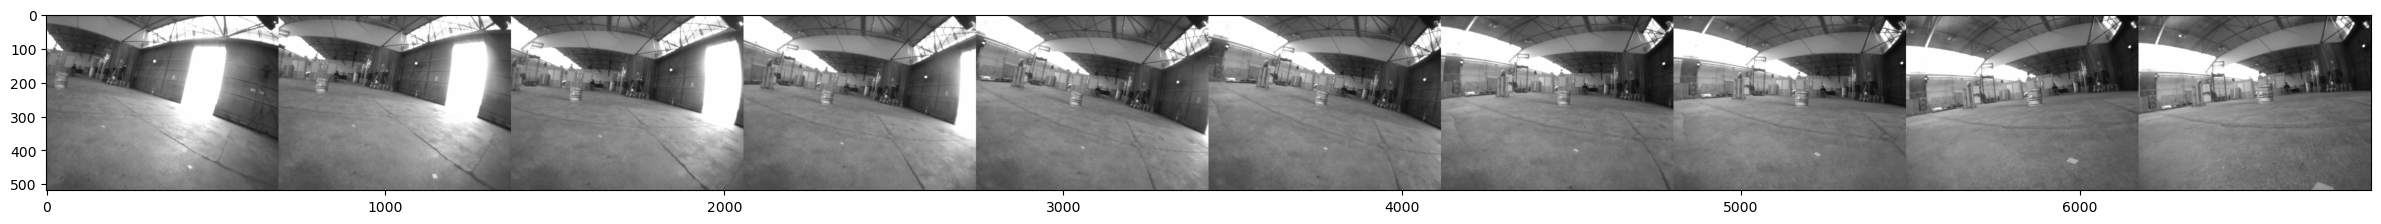

In [9]:
plt.figure(figsize=(30, 10))
plt.imshow(np.concatenate(tuple(data["cam0"].cpu().permute(0,2,3,1)), axis=1));

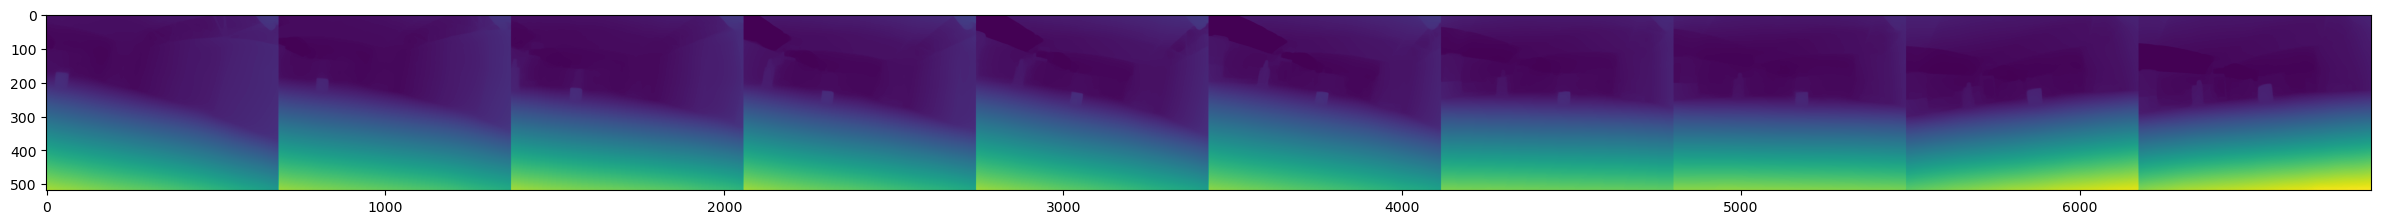

In [11]:
plt.figure(figsize=(30, 10))
plt.imshow(np.concatenate(tuple(depths.cpu()), axis=1));

### Visualize Poses and Points for Initialized Conditions

In [19]:
# Initialize two new dictionaries
cam2points2d = defaultdict(list)
cam2points3d = defaultdict(list)

# Iterate over each item in the original dictionary
for key, value_list in cam2point.items():
    for value in value_list:
        # Unpack each tuple
        point2d, point3d = value
        # Append the first element of the tuple to cam2points2d
        cam2points2d[key].append(point2d)
        # Append the second element of the tuple to cam2points3d
        cam2points3d[key].append(point3d)

### Bundle Adjustment

In [36]:
poses_gt.shape

torch.Size([200, 7])

In [41]:
### CPU for debugging ###
Kcpu = K.cpu()
points2D = {i:v['keypoints'][0].cpu() for i,v in enumerate(feature_points)}
poses_gt = torch.vstack(gt_poses).cpu()
points = nn.Parameter(points3D.cpu())
poses_pred = pp.Parameter(poses.cpu())

# Initialize the optimizer
optimizer = torch.optim.Adam([points, poses_pred], lr=1e-3)
lossf = nn.MSELoss()
# Run Bundle Adjustment
n_iter = 200  # fix the number of iterations
pose_loss_b4 = (poses_pred.Inv() @ poses_gt).sum()

for it in range(n_iter):
    optimizer.zero_grad()

    loss = 0

    for cam in range(imu_poses.shape[0]):
        indices = cam2point[cam]
        pts3d = points[cam2points3d[cam]]
        pts2d = points2D[cam][cam2points2d[cam]]
        pose = poses_pred[cam]
        loss = loss + pp.reprojerr(pts3d, pts2d, Kcpu, pose, reduction='norm').sum()

    loss = loss + 1000*(poses_pred.Inv() @ poses_gt).sum()
        
    # our loss function is the camera_distance
    loss.backward()
    
    # apply the gradients
    optimizer.step()

    print(f"Loss : {loss.item()}")

print('Optimization finished.')
print(f"Pose Loss Before {pose_loss_b4} => Pose Loss After {(poses_pred.Inv() @ poses_gt).sum()}")

Loss : 869427008.0
Loss : 54321308.0
Loss : 62493812.0
Loss : 29551674.0
Loss : 45971700.0
Loss : 32105914.0
Loss : 66880252.0
Loss : 32821342.0
Loss : 29107374.0
Loss : 99000512.0
Loss : 87947880.0
Loss : 63693120.0
Loss : 29468336.0
Loss : 27358652.0
Loss : 29744734.0
Loss : 62711220.0
Loss : 30833138.0
Loss : 166021328.0
Loss : 51978312.0
Loss : 26335284.0
Loss : 34922112.0
Loss : 33637440.0
Loss : 29732538.0
Loss : 33571060.0
Loss : 32557280.0
Loss : 33289162.0
Loss : 27841024.0
Loss : 24655452.0
Loss : 25208466.0
Loss : 38315720.0
Loss : 25534956.0
Loss : 29212054.0
Loss : 34673372.0
Loss : 28826834.0
Loss : 897712768.0
Loss : 24130148.0
Loss : 28764468.0
Loss : 23705842.0
Loss : 23478590.0
Loss : 31828500.0
Loss : 1690898048.0
Loss : 152473328.0
Loss : 21565530.0
Loss : 21817058.0
Loss : 22922498.0
Loss : 21749224.0
Loss : 21848218.0
Loss : 27919606.0
Loss : 25161670.0
Loss : 44375444.0
Loss : 35700772.0
Loss : 22250970.0
Loss : 22946902.0
Loss : 37631244.0
Loss : 23794410.0
Loss

In [44]:
visualize_batch(poses_pred.detach(), poses_gt, points.data)